In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer
import warnings

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.width", 1000)
warnings.filterwarnings("ignore")


In [2]:
def check_data(dataframe, head=5):
    print ("####### SHAPE #######")
    print (dataframe.shape)
    print ("####### INFO #######")
    print (dataframe.info ())
    print ("####### DESCRIBE #######")
    print (dataframe.describe ([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]))
    print ("####### NA VALUES #######")
    print (dataframe.isnull ().sum ())
    print ("####### FIRST {} ROWS #######".format (head))
    print (dataframe.head (head))


def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    """
    Calculate lower and upper bounds for detecting outliers using the IQR (Interquartile Range) method.

    Parameters:
    -------
        dataframe (DataFrame): The DataFrame containing the data.
        col_name (str): The name of the column for which to calculate the outlier thresholds.
        q1 (float, optional): The lower quartile value (default is 0.25).
        q3 (float, optional): The upper quartile value (default is 0.75).

    Returns:
    ------
        float: The lower threshold for outliers.
        float: The upper threshold for outliers.
    """
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95)
    if ( dataframe[ (dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit) ].any(axis =None) ):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe,variable,
                                              q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def select_country(dataframe, country):
   new_dataframe = dataframe.loc[dataframe["Country"]==country]
   return new_dataframe


def plot_histogram(dataframe, column_name, bins=20):
    """
    Plots a histogram of a specific column in the given DataFrame.

    Parameters:
        data (pandas.DataFrame): The DataFrame for which the histogram will be plotted.
        column_name (str): The name of the column for which the histogram will be plotted.
        num_bins (int, optional): The number of bins in the histogram. Default is 20.
    """
    dataframe[column_name].hist(bins=bins)
    plt.title(column_name)
    plt.show()

def segment_analysis_and_visualization(dataframe, segment_col, summary_args):
    """
    The function performs segment analysis and visualization on a given DataFrame using a specified
    segmentation column and summary statistics.

    Parameters:
        dataframe (pandas.DataFrame): The DataFrame containing the data.
        segment_col (str): The column that represents the segments created by the segmentation method.
        summary_args (dict): A dictionary specifying the summary statistics to be calculated for each feature.
    Returns:
        None (Displays analysis and visualizations).

    """
    dataframe.groupby(segment_col).agg(summary_args)
    print(f"Summary for {segment_col}:")
    plt.figure(figsize=(20, 10))
    sns.boxplot(x=segment_col, y="Monetary", data=dataframe)
    plt.title(f"Box Plot of Monetary by {segment_col}")
    plt.show()


In [6]:
df = pd.read_excel("/content/drive/MyDrive/K-Means Customer Segmentation/dataset/online_retail_II-230817-120704.xlsx", sheet_name="Year 2009-2010")
check_data(df)

####### SHAPE #######
(525461, 8)
####### INFO #######
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None
####### DESCRIBE #######
       Quantity     Price  Customer ID
count 525461.00 525461.00    417534.00
mean      10.34      4.69     15360.65
std      107.42    146.13      1680.81
min    -9600.00 -53594.36     12346.00
1%        -3.00      0.21   

In [7]:
#If Invoice code starts with 'C' it means the operation has been canceled
df = df[~df["Invoice"].str.contains("C", na=False)]

In [8]:
df = df[df["Quantity"] > 0]
df.dropna(inplace=True)

df["StockCode"]=="M"

0         False
1         False
2         False
3         False
4         False
          ...  
525456    False
525457    False
525458    False
525459    False
525460    False
Name: StockCode, Length: 407695, dtype: bool

In [9]:
df = df[df["StockCode"] != 'M']

df["TotalPrice"] = df["Quantity"] * df["Price"]

df[df["Price"] == 0]["StockCode"].unique ()

array([22076, 48185, 22065, 22142, 85042, 21143, 79320, 22355, 21533,
       'TEST001', 21662, 22459, 22458, 22376, 21765, 20914, 22423, 22690,
       22472, 22202, '46000M', 22218, 22630, 22121, 21843, 22624, 22846,
       22845, 22841], dtype=object)

In [10]:
# Extracts unique StockCodes with at least three letters in the StockCode column.
invalid_codes = df[df["StockCode"].astype(str).str.contains(r"[a-zA-Z]{3,}")]["StockCode"].unique().tolist()

invalid_codes

['POST', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS', 'ADJUST', 'ADJUST2']

In [11]:
df[df["StockCode"].isin (invalid_codes)].groupby (["StockCode"]).agg ({"Invoice": "nunique",
                                                                        "Quantity": "sum",
                                                                        "Price": "sum",
                                                                        "Customer ID": "nunique"})

,Invoice,Quantity,Price,Customer ID
StockCode,,,,
ADJUST,32,32,3538.52,25
ADJUST2,3,3,731.05,3
BANK CHARGES,20,20,300.00,12
PADS,14,14,0.01,12
POST,738,2212,19964.83,230
TEST001,11,60,40.50,4
TEST002,1,1,1.00,1


In [12]:
df = df[~df["StockCode"].isin(invalid_codes)].reset_index(drop=True)


In [15]:
max_invoice_date = df["InvoiceDate"].max()
today_date= max_invoice_date + dt.timedelta(days=2)

rfm = df.groupby("Customer ID").agg({"InvoiceDate": lambda date: (today_date - date.max()).days,
                                     "Invoice":"nunique",
                                     "TotalPrice":"sum"})

rfm.head(10)

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.00,166,2,169.36
12347.00,4,2,1323.32
12348.00,75,1,221.16
12349.00,44,2,2221.14
12351.00,12,1,300.93
12352.00,12,2,343.80
12353.00,45,1,317.76
12355.00,204,1,488.21
12356.00,17,3,3126.25


In [16]:
rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm = rfm[(rfm["Frequency"] > 0) & (rfm["Monetary"] > 0)]


In [17]:
for col in rfm.columns:
    print(check_outlier(rfm, col))




False
True
True


In [18]:
for col in rfm.columns:
    replace_with_thresholds(rfm, col)

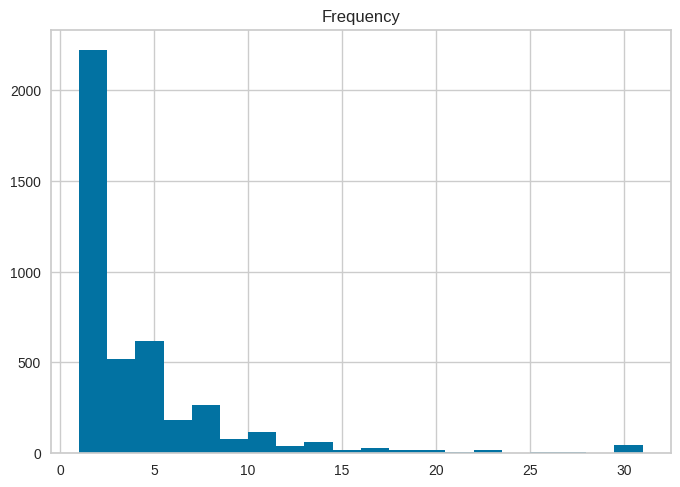

In [19]:
plot_histogram(rfm, "Frequency")

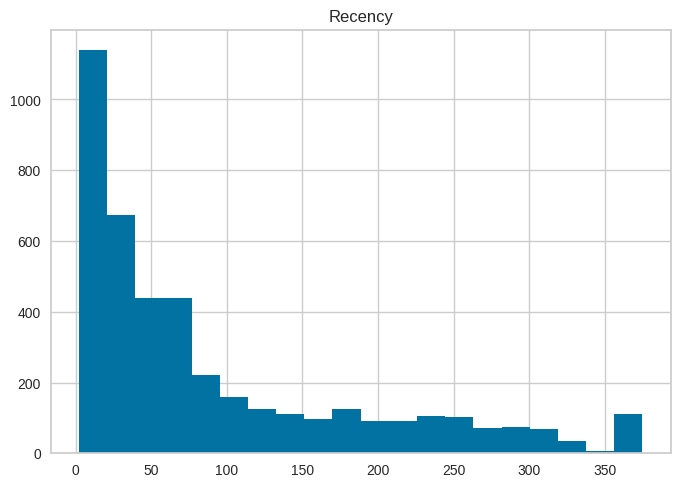

In [20]:
plot_histogram(rfm, "Recency")

In [21]:
# LOG Transformation
for col in ["Frequency", "Recency"]:
    rfm[f"LOG_{col}"] = np.log1p(rfm[col])

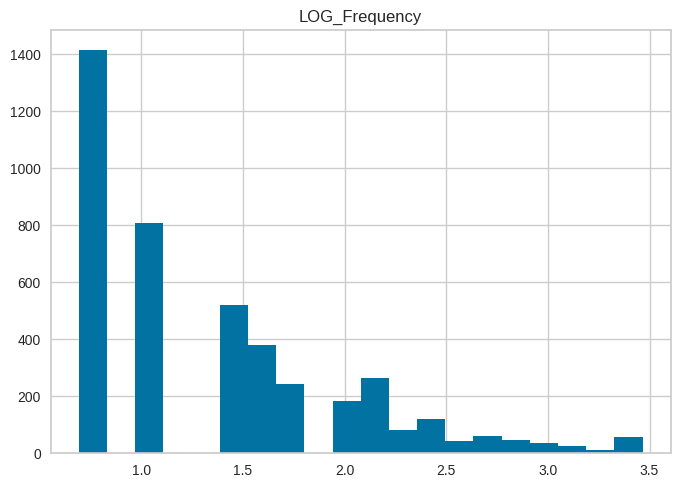

In [23]:
plot_histogram(rfm, "LOG_Frequency")

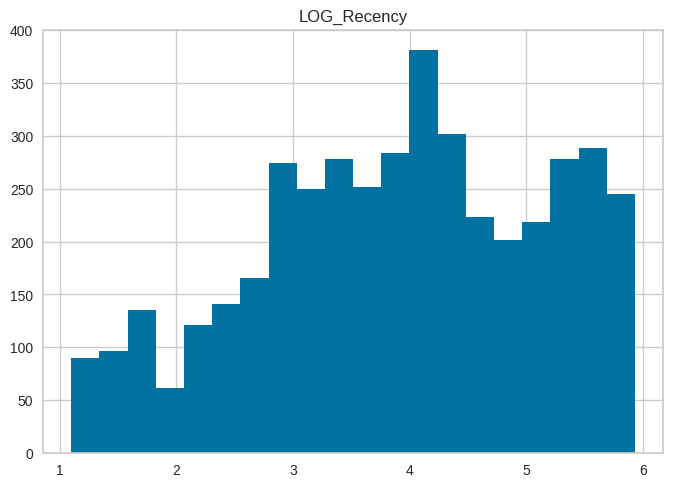

In [24]:
plot_histogram(rfm, "LOG_Recency")

In [25]:
# ****NORMALIZATION****

sc = StandardScaler()
sc.fit (rfm[["LOG_Recency", "LOG_Frequency"]])
scaled_rf = sc.transform (rfm[["LOG_Recency", "LOG_Frequency"]])

scaled_df = pd.DataFrame(index=rfm.index, columns=["LOG_Recency", "LOG_Frequency"], data=scaled_rf)
scaled_df.head()

,LOG_Recency,LOG_Frequency
Customer ID,,
12346.00,0.99,-0.40
12347.00,-1.85,-0.40
12348.00,0.35,-1.00
12349.00,-0.07,-0.40
12351.00,-1.08,-1.00


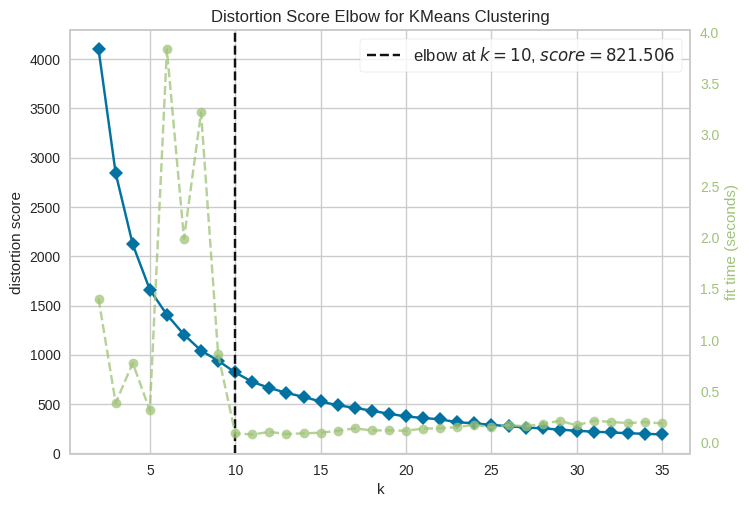

10

In [26]:
# Determining optimal number of cluster

kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=35)
elbow.fit(scaled_df)
elbow.show()
best_k = elbow.elbow_value_

best_k

In [27]:
k_means = KMeans(n_clusters=best_k, ).fit(scaled_df)
labels = k_means.labels_


In [29]:
rfm["KMeansCluster"] = labels

rfm.tail(20)


,Recency,Frequency,Monetary,LOG_Frequency,LOG_Recency,KMeansCluster
Customer ID,,,,,,
18266.00,71.00,1,251.10,0.69,4.28,4
18267.00,309.00,1,269.37,0.69,5.74,1
18268.00,228.00,5,1464.73,1.79,5.43,8
18269.00,3.00,1,168.60,0.69,1.39,5
18270.00,69.00,1,161.40,0.69,4.25,4
18271.00,246.00,2,680.85,1.10,5.51,8
18272.00,185.00,3,1307.40,1.39,5.23,8
18273.00,227.00,1,153.00,0.69,5.43,1
18275.00,215.00,2,741.85,1.10,5.38,8


In [30]:
rfm.shape

(4286, 6)

In [31]:
args = {"Recency": ["mean", "median", "count"],
                    "Frequency":["mean", "median", "count"],
                    "Monetary": ["mean", "median", "count"]}


Summary for KMeansCluster:


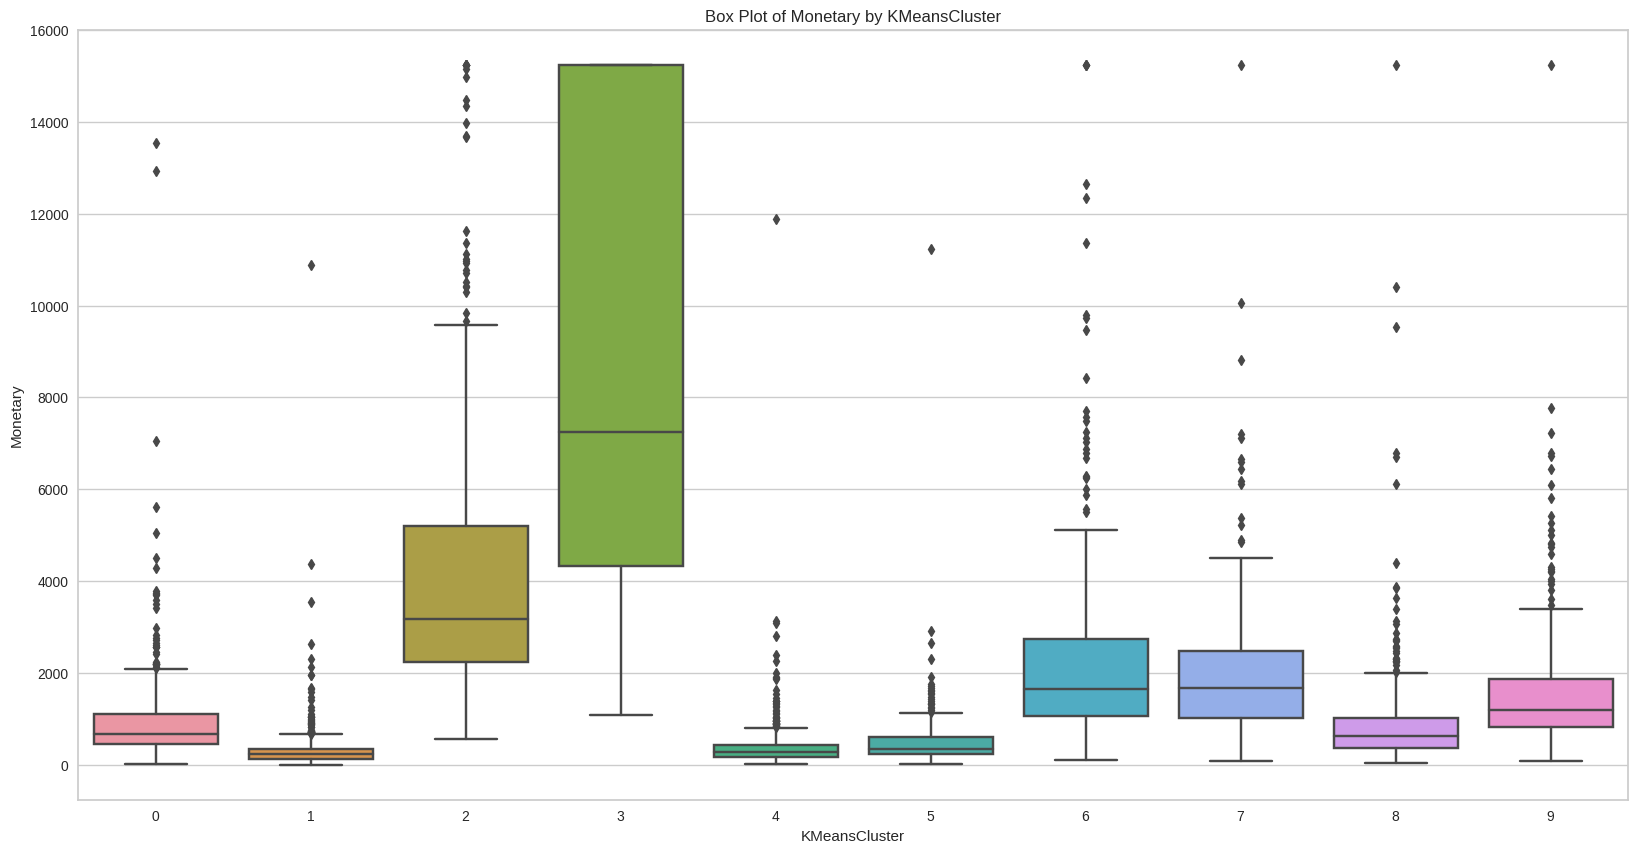

In [39]:
segment_analysis_and_visualization(rfm,"KMeansCluster", args)


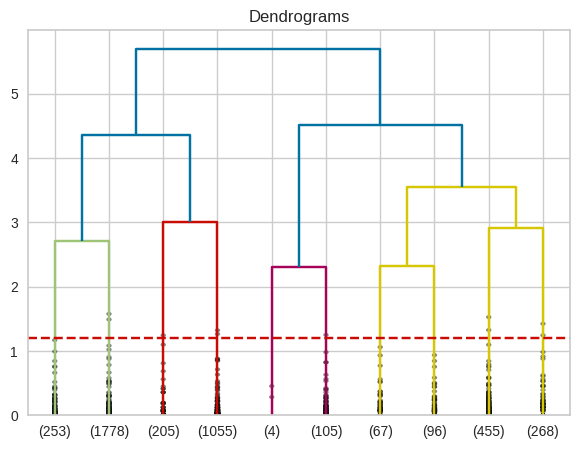

In [40]:
### ***Hierarchical Clustering***

hc_complete = linkage(scaled_df,"complete")

plt.figure (figsize=(7, 5))
plt.title ("Dendrograms")
dend = dendrogram (hc_complete,
                   truncate_mode="lastp",
                   p=10,
                   show_contracted=True,
                   leaf_font_size=10)
plt.axhline (y=1.2, color='r', linestyle='--')
plt.show ()

Summary for Hierarchical_Segments:


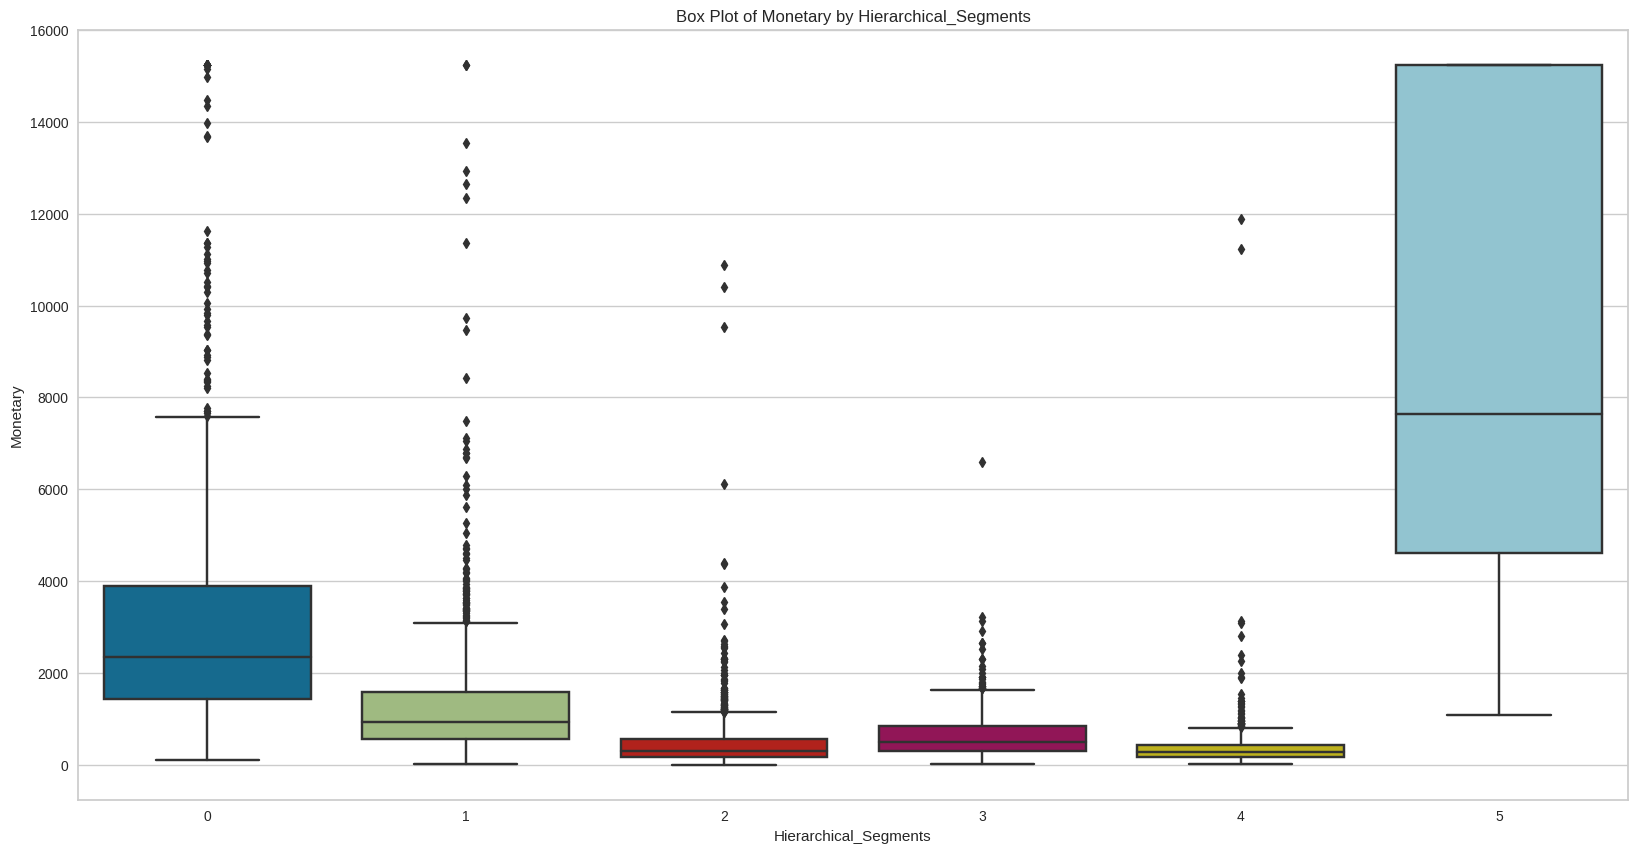

In [41]:
hc = AgglomerativeClustering(n_clusters=6, )
segments= hc.fit_predict(scaled_df)
rfm["Hierarchical_Segments"] = segments

segment_analysis_and_visualization(rfm,"Hierarchical_Segments", args)